In [1]:
import tensorflow as tf
import numpy as np

2023-02-26 14:04:46.028023: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
classes = [
'Tomato___Late_blight',
'Tomato___healthy',
'Tomato___Early_blight',
'Tomato___Septoria_leaf_spot',
'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
'Tomato___Bacterial_spot',
'Tomato___Target_Spot',
'Tomato___Tomato_mosaic_virus',
'Tomato___Leaf_Mold',
'Tomato___Spider_mites Two-spotted_spider_mite'
]

# ImageDatagenerator
 > this tool is used in tensorflow to fetch images from a specified directory
 > apply transformations on it such as rescaling, zooming, flipping shuffling e.t.c
 # Our dataset
 > our dataset has already been split into two folders
 * train
 * validation
> Each of the following folder contains the following folders
* Tomato___Late_blight
* Tomato___healthy
* Tomato___Early_blight
* Tomato___Septoria_leaf_spot
* Tomato___Tomato_Yellow_Leaf_Curl_Virus
* Tomato___Bacterial_spot
* Tomato___Target_spot
* Tomato___Tomator_mosaic_virus
* Tomato___Leaf_Mold
* Tomato___Spider_mites Two-spotted_spider_mite


> Each of the folder contains images that correspond to the folder name 

In [3]:
BATCH_SIZE = 100
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [4]:
from keras.preprocessing.image import ImageDataGenerator
train_dir = '/Users/msughter/Downloads/tomato/train'
validation_dir = '/Users/msughter/Downloads/tomato/val'
# Image datagenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_datagenerator = train_datagen.flow_from_directory(
     train_dir,
        batch_size=BATCH_SIZE,
        shuffle=True,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        classes = classes,
)

validation_datagenerator = validation_datagen.flow_from_directory(
    validation_dir,
     target_size=(IMG_HEIGHT, IMG_WIDTH),
        classes = classes,
        batch_size=BATCH_SIZE
)

Found 10000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


> as you can see there 11000 images that were found
> 10000 belonging to training.
> 1000 belonging to validation.
> This means it was splitted into 90% training and 10% validation by the researchers
> we would use the datagenerators to augment both the training and validation dataset
> we would then split the validation into 5% validation and 95%

# MobilenetV2 pretrained model
> The mobilenetv2 is trained on the imagenet dataset which has millions of images grouped into 1000 classes.
> we group the entire model into two parts
* The feature extraction layer (that has multiple convolutional and maxpooling layer) whose responsibility is to convert the image from an array of shape (224,224,3) into flattened array of shape 320.
* The Classification layer takes in the flattened array of size 320
  and predicts the class the image falls into by outputing an array of 1000 numbers each specifying the probality of the image being one of the labelled classes. the index with the highest probability is the predicted class
> Tensorflow provides built in tools to help us easily download and modify this model
> it has a parameter called inlude_top which we use to tell tensorflow if we want to keep the fully connected classification layer or not.
> in our case we have no use for it so we dropped it completely.

![mobilenetv2](/Users/msughter/projects/droneai/androidai/Shoping-list/mobilnetv2_architecture.jpeg)

In [5]:
# load the pretrained model
pretrained_model = tf.keras.models.load_model('/Users/msughter/projects/droneai/resources/my_final_model.h5')
# truncate the pretrainded model


2023-02-26 14:05:17.213130: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
# build the feature extraction model from the pretrained model
feature_extractor = tf.keras.Model(inputs=pretrained_model.input,outputs=[pretrained_model.layers[-2].output])
feature_extractor.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224_input   [(None, 224, 224, 3)]    0         
 (InputLayer)                                                    
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 320)               409920    
                                                                 
 dropout (Dropout)           (None, 320)               0         
                                                             

# Infinite data generation and feature extraction
> Our data generator is capable of fetching the stored images, applying transformations and generating an infinite amount of images. we provide it with the number of augmentations we want it to do so it would stop when it arrives at that number.
&nbsp; 
&nbsp; \
\
\
> While fetching and augmenting the data, we use our feature extraction model to extract the features from the  images and store them so we would later use them to train our svm.

In [7]:
def extract_features(datagen,iterations):
    features = []
    labels = []
    i = 1
    for _,(image_batch,label_batch) in enumerate(datagen):
        if i > iterations:
            break
        print(f'extracting features for batch.....{i}')
        batch_features = feature_extractor.predict(image_batch)
        labels_list =  np.argmax(label_batch,axis=1)
        for img, label in zip(batch_features,labels_list):
            features.append(img)
            labels.append(label)
        i+=1
    return features, labels
        

In [8]:
train_x, train_y = extract_features(train_datagenerator,150)

extracting features for batch.....1
4/4 [==============================] - 4s 556ms/step
extracting features for batch.....2
4/4 [==============================] - 3s 564ms/step
extracting features for batch.....3
4/4 [==============================] - 3s 602ms/step
extracting features for batch.....4
4/4 [==============================] - 3s 678ms/step
extracting features for batch.....5
4/4 [==============================] - 2s 566ms/step
extracting features for batch.....6
4/4 [==============================] - 3s 577ms/step
extracting features for batch.....7
4/4 [==============================] - 3s 578ms/step
extracting features for batch.....8
4/4 [==============================] - 2s 570ms/step
extracting features for batch.....9
4/4 [==============================] - 3s 572ms/step
extracting features for batch.....10
4/4 [==============================] - 3s 568ms/step
extracting features for batch.....11
4/4 [==============================] - 2s 547ms/step
extracting features

In [9]:
validation_test_features,validation_test_labels = extract_features(validation_datagenerator,20)

extracting features for batch.....1
4/4 [==============================] - 2s 430ms/step
extracting features for batch.....2
4/4 [==============================] - 2s 441ms/step
extracting features for batch.....3
4/4 [==============================] - 2s 451ms/step
extracting features for batch.....4
4/4 [==============================] - 2s 461ms/step
extracting features for batch.....5
4/4 [==============================] - 2s 516ms/step
extracting features for batch.....6
4/4 [==============================] - 2s 427ms/step
extracting features for batch.....7
4/4 [==============================] - 2s 432ms/step
extracting features for batch.....8
4/4 [==============================] - 2s 448ms/step
extracting features for batch.....9
4/4 [==============================] - 2s 428ms/step
extracting features for batch.....10
4/4 [==============================] - 2s 418ms/step
extracting features for batch.....11
4/4 [==============================] - 2s 428ms/step
extracting features

In [10]:
print(f'Training data is now {len(train_x)} an increase by {len(train_x)-10000} through augmentation')
print(f'Validation data is now {len(validation_test_features)} an increase by {len(validation_test_features)-1000} through augmentation')

Training data is now 15000 an increase by 5000 through augmentation
Validation data is now 2000 an increase by 1000 through augmentation


## Splitting the validation data
> since the dataset has already been split into train and validation
> we split the validation data into 95% test and 5% validation

In [11]:
from sklearn.model_selection import train_test_split
# we would use the sklearn train_test_split to 
# split the validation dataset into 95% test and 5% validation 
val_x,test_x,val_y, test_y= train_test_split(validation_test_features,validation_test_labels,test_size=0.95, random_state=42)

In [40]:
# add the validation and training data into X and Y

X_data = []
Y_data = []

# training data
for x,y in zip(train_x,train_y):
    X_data.append(x)
    Y_data.append(y)
    
# validation data
for x,y in zip(val_x,val_y):
    X_data.append(x)
    Y_data.append(y)

# Training the SVM
> we attempt training the a polynomial svm at degree 1,2,3
> by varying the degree parameter we would see how it affects the performance

In [12]:
from sklearn import svm

In [13]:
poly = svm.SVC(kernel='poly', degree=3, C=1).fit(train_x, train_y)

In [14]:
# importing some evaluationn metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

Accuracy (POLY Kernel):  100.00
F1 (POLY Kernel):  100.00


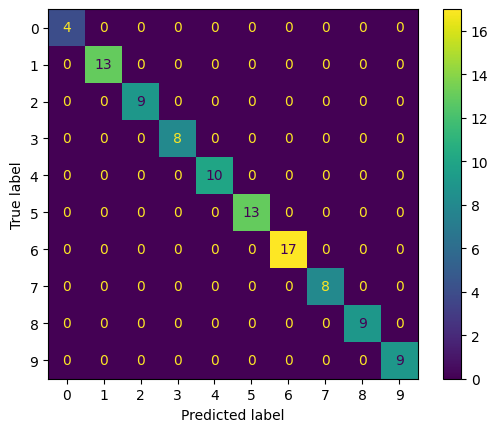

In [15]:
poly_pred_val = poly.predict(val_x)
poly_accuracy_val = accuracy_score(val_y, poly_pred_val)
poly_f1_val = f1_score(val_y, poly_pred_val, average='weighted')
cm = confusion_matrix(val_y, poly_pred_val,labels=poly.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=poly.classes_)
disp.plot()
print('Accuracy (POLY Kernel): ', "%.2f" % (poly_accuracy_val*100))
print('F1 (POLY Kernel): ', "%.2f" % (poly_f1_val*100))

Accuracy (POLY Kernel):  99.16
F1 (POLY Kernel):  99.16


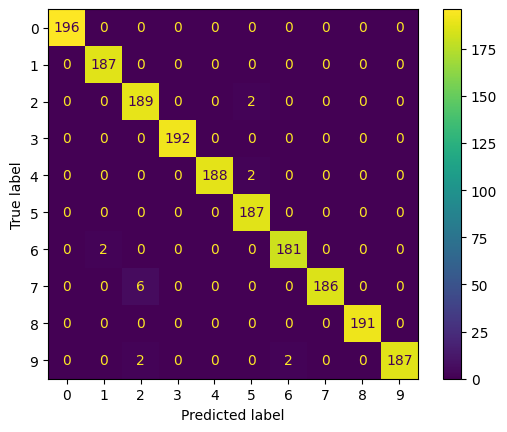

In [16]:
poly_pred_test = poly.predict(test_x)
poly_accuracy_test = accuracy_score(test_y, poly_pred_test)
poly_f1_test = f1_score(test_y, poly_pred_test, average='weighted')
cm = confusion_matrix(test_y, poly_pred_test,labels=poly.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=poly.classes_)
disp.plot()
print('Accuracy (POLY Kernel): ', "%.2f" % (poly_accuracy_test*100))
print('F1 (POLY Kernel): ', "%.2f" % (poly_f1_test*100))

In [17]:
# Change the degree of the SVM classifier to 2
poly2 = svm.SVC(kernel='poly', degree=2, C=1).fit(train_x, train_y)

Accuracy (Poly2 Kernel with degree 2):  100.00
F1 (Poly2 Kernel with degree 2):  100.00


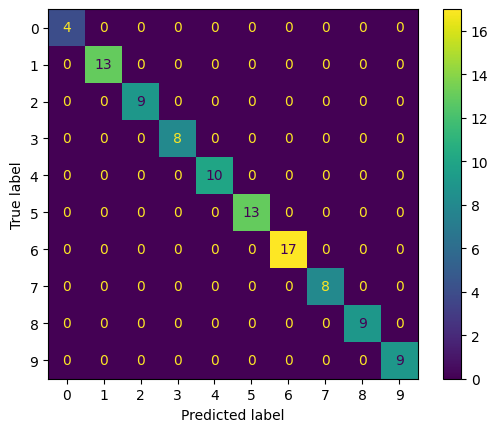

In [18]:
poly2_pred_val = poly2.predict(val_x)
poly2_accuracy_val = accuracy_score(val_y, poly2_pred_val)
poly2_f1_val = f1_score(val_y, poly2_pred_val, average='weighted')
cm = confusion_matrix(val_y, poly2_pred_val,labels=poly2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=poly2.classes_)
disp.plot()
print('Accuracy (Poly2 Kernel with degree 2): ', "%.2f" % (poly2_accuracy_val*100))
print('F1 (Poly2 Kernel with degree 2): ', "%.2f" % (poly2_f1_val*100))

Accuracy (Poly2 Kernel with degree 2):  99.26
F1 (Poly2 Kernel with degree 2):  99.26


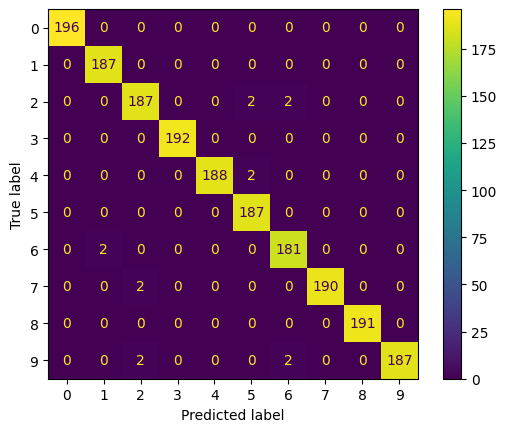

In [19]:
# changing the degree to 2 has boosted the performance a bit
poly2_pred_test = poly2.predict(test_x)
poly2_accuracy_test = accuracy_score(test_y, poly2_pred_test)
poly2_f1_test = f1_score(test_y, poly2_pred_test, average='weighted')
cm = confusion_matrix(test_y, poly2_pred_test,labels=poly2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=poly2.classes_)
disp.plot()
print('Accuracy (Poly2 Kernel with degree 2): ', "%.2f" % (poly2_accuracy_test*100))
print('F1 (Poly2 Kernel with degree 2): ', "%.2f" % (poly2_f1_test*100))

In [20]:
# change the degree to 1
poly1 = svm.SVC(kernel='poly', degree=1, C=1).fit(train_x, train_y)

Accuracy (Poly1 Kernel with degree 1):  100.00
F1 (Poly1 Kernel with degree 1):  100.00


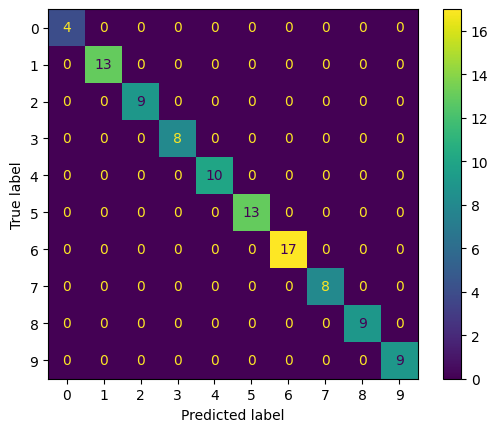

In [21]:
poly1_pred_val = poly1.predict(val_x)
poly1_accuracy_val = accuracy_score(val_y, poly1_pred_val)
poly1_f1_val = f1_score(val_y, poly1_pred_val, average='weighted')
cm = confusion_matrix(val_y, poly1_pred_val,labels=poly1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=poly1.classes_)
disp.plot()
print('Accuracy (Poly1 Kernel with degree 1): ', "%.2f" % (poly1_accuracy_val*100))
print('F1 (Poly1 Kernel with degree 1): ', "%.2f" % (poly1_f1_val*100))

Accuracy (Poly1 Kernel with degree 1):  99.16
F1 (Poly1 Kernel with degree 1):  99.16


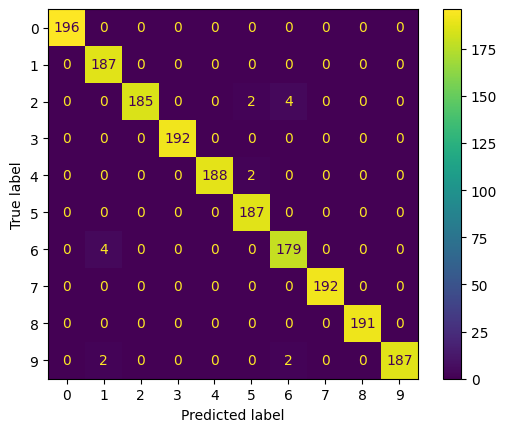

In [22]:
poly1_pred_test = poly1.predict(test_x)
poly1_accuracy_test = accuracy_score(test_y, poly1_pred_test)
poly1_f1_test = f1_score(test_y, poly1_pred_test, average='weighted')
cm = confusion_matrix(test_y, poly1_pred_test,labels=poly1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=poly1.classes_)
disp.plot()
print('Accuracy (Poly1 Kernel with degree 1): ', "%.2f" % (poly1_accuracy_test*100))
print('F1 (Poly1 Kernel with degree 1): ', "%.2f" % (poly1_f1_test*100))

In [23]:
# lets try tuning some parameters of svm with kernel
# change the degree to 2
poly2 = svm.SVC(kernel='poly', degree=2, C=1).fit(train_x, train_y)


Accuracy (Poly2 Kernel with degree 2):  100.00
F1 (Poly2 Kernel with degree 2):  100.00


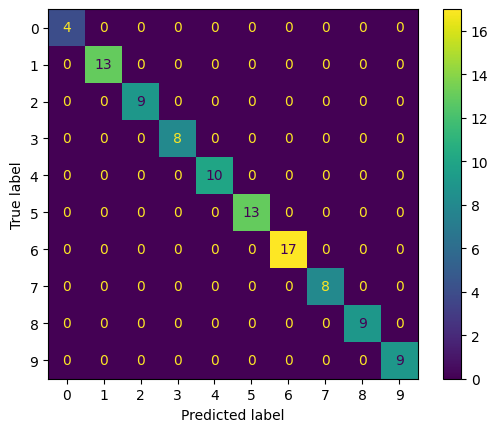

In [24]:

poly2_pred_val = poly2.predict(val_x)
poly2_accuracy_val = accuracy_score(val_y, poly2_pred_val)
poly2_f1_val = f1_score(val_y, poly2_pred_val, average='weighted')
cm = confusion_matrix(val_y, poly2_pred_val,labels=poly2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=poly2.classes_)
disp.plot()
print('Accuracy (Poly2 Kernel with degree 2): ', "%.2f" % (poly2_accuracy_val*100))
print('F1 (Poly2 Kernel with degree 2): ', "%.2f" % (poly2_f1_val*100))

Accuracy (Poly2 Kernel with degree 2):  99.26
F1 (Poly2 Kernel with degree 2):  99.26


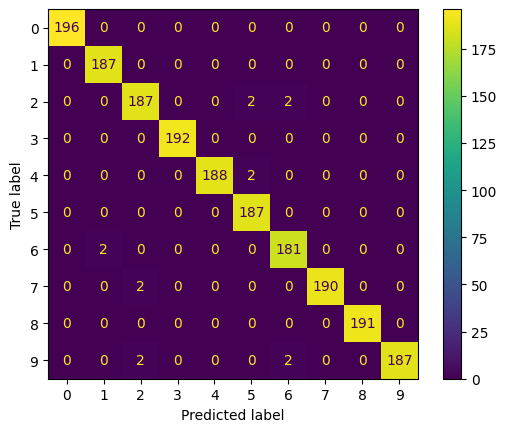

In [25]:

poly2_pred_test = poly2.predict(test_x)
poly2_accuracy_test = accuracy_score(test_y, poly2_pred_test)
poly2_f1_test = f1_score(test_y, poly2_pred_test, average='weighted')
cm = confusion_matrix(test_y, poly2_pred_test,labels=poly2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=poly2.classes_)
disp.plot()
print('Accuracy (Poly2 Kernel with degree 2): ', "%.2f" % (poly2_accuracy_test*100))
print('F1 (Poly2 Kernel with degree 2): ', "%.2f" % (poly2_f1_test*100))

In [26]:
# change the degree to 1
poly1 = svm.SVC(kernel='poly', degree=1, C=1).fit(train_x, train_y)

Accuracy (Poly1 Kernel with degree 1):  100.00
F1 (Poly1 Kernel with degree 1):  100.00


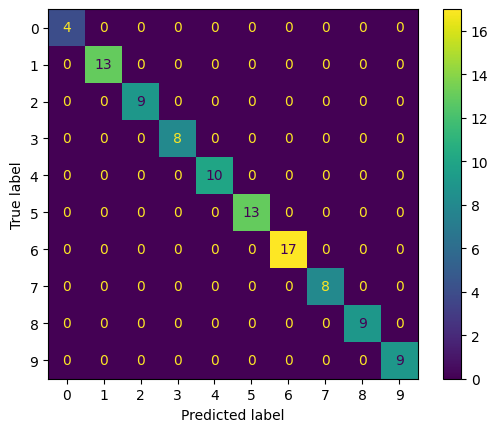

In [27]:
poly1_pred_val = poly1.predict(val_x)
poly1_accuracy_val = accuracy_score(val_y, poly1_pred_val)
poly1_f1_val = f1_score(val_y, poly1_pred_val, average='weighted')
cm = confusion_matrix(val_y, poly1_pred_val,labels=poly1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=poly1.classes_)
disp.plot()
print('Accuracy (Poly1 Kernel with degree 1): ', "%.2f" % (poly1_accuracy_val*100))
print('F1 (Poly1 Kernel with degree 1): ', "%.2f" % (poly1_f1_val*100))

Accuracy (Poly1 Kernel with degree 1):  99.16
F1 (Poly1 Kernel with degree 1):  99.16


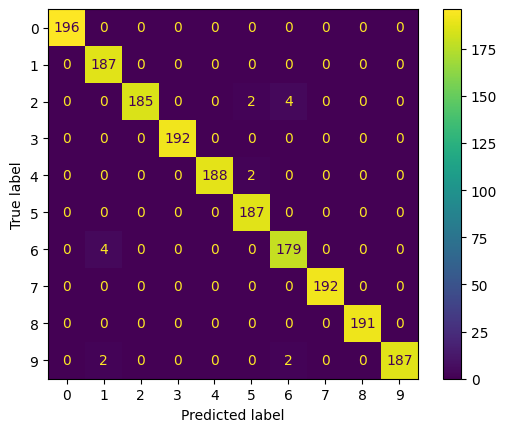

In [28]:

poly1_pred_test = poly1.predict(test_x)
poly1_accuracy_test = accuracy_score(test_y, poly1_pred_test)
poly1_f1_test = f1_score(test_y, poly1_pred_test, average='weighted')
cm = confusion_matrix(test_y, poly1_pred_test,labels=poly1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=poly1.classes_)
disp.plot()
print('Accuracy (Poly1 Kernel with degree 1): ', "%.2f" % (poly1_accuracy_test*100))
print('F1 (Poly1 Kernel with degree 1): ', "%.2f" % (poly1_f1_test*100))

In [49]:
# generating classification report
from sklearn.metrics import classification_report
report_3 = classification_report(test_y,poly1_pred_test)
print(report_3)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       196
           1       0.97      1.00      0.98       187
           2       1.00      0.97      0.98       191
           3       1.00      1.00      1.00       192
           4       1.00      0.99      0.99       190
           5       0.98      1.00      0.99       187
           6       0.97      0.98      0.97       183
           7       1.00      1.00      1.00       192
           8       1.00      1.00      1.00       191
           9       1.00      0.98      0.99       191

    accuracy                           0.99      1900
   macro avg       0.99      0.99      0.99      1900
weighted avg       0.99      0.99      0.99      1900



In [50]:
# This classification report is for the 2 polynomial svm model
report_2 = classification_report(test_y,poly2_pred_test)
print(report_2)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       196
           1       0.99      1.00      0.99       187
           2       0.98      0.98      0.98       191
           3       1.00      1.00      1.00       192
           4       1.00      0.99      0.99       190
           5       0.98      1.00      0.99       187
           6       0.98      0.99      0.98       183
           7       1.00      0.99      0.99       192
           8       1.00      1.00      1.00       191
           9       1.00      0.98      0.99       191

    accuracy                           0.99      1900
   macro avg       0.99      0.99      0.99      1900
weighted avg       0.99      0.99      0.99      1900



In [51]:
# This classification report is for the first polynomial svm model
report_1 = classification_report(test_y,poly_pred_test)
print(report_1)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       196
           1       0.99      1.00      0.99       187
           2       0.96      0.99      0.97       191
           3       1.00      1.00      1.00       192
           4       1.00      0.99      0.99       190
           5       0.98      1.00      0.99       187
           6       0.99      0.99      0.99       183
           7       1.00      0.97      0.98       192
           8       1.00      1.00      1.00       191
           9       1.00      0.98      0.99       191

    accuracy                           0.99      1900
   macro avg       0.99      0.99      0.99      1900
weighted avg       0.99      0.99      0.99      1900



In [44]:
# create the svm classifier to show the learning curve of the model
from sklearn.model_selection import learning_curve
from sklearn.model_selection import  ShuffleSplit
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
# add noisy features
# Add noisy features
random_state = np.random.RandomState(0)

# Use label_binarize to be multi-label like settings
Y = label_binarize(Y_data, classes=[0, 1, 2,3,4,5,6,7,8,9])
n_classes = Y.shape[1]

# Split into training and test
X_train, X_test, Y_train, Y_test = train_test_split(
    X_data, Y, test_size=0.5, random_state=random_state
)

classifier = OneVsRestClassifier(
    make_pipeline(StandardScaler(), poly)
)
classifier.fit(X_train, Y_train)
y_score = classifier.decision_function(X_test)

In [45]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(
    Y_test.ravel(), y_score.ravel()
)
average_precision["micro"] = average_precision_score(Y_test, y_score, average="micro")

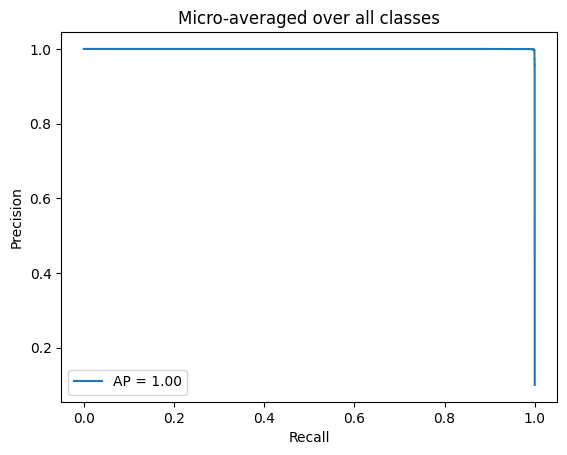

In [46]:
display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot()
_ = display.ax_.set_title("Micro-averaged over all classes")

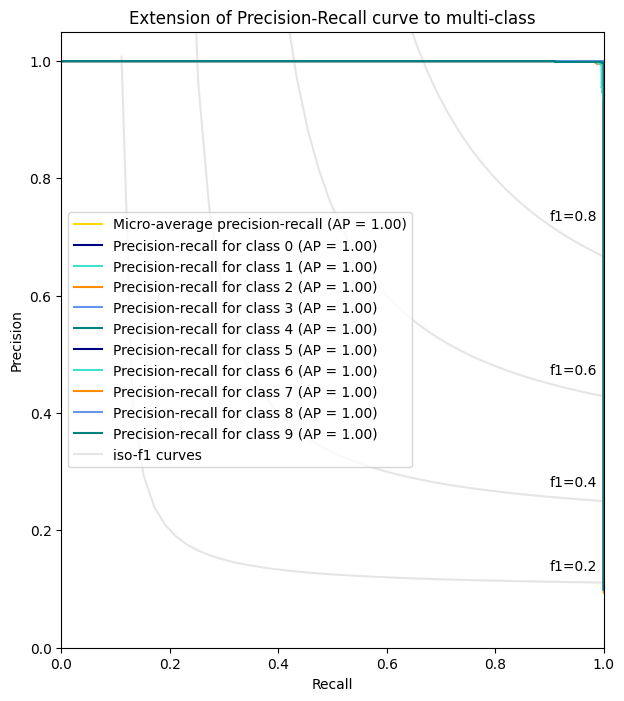

In [47]:
import matplotlib.pyplot as plt
from itertools import cycle

# setup plot details
colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])

_, ax = plt.subplots(figsize=(7, 8))

f_scores = np.linspace(0.2, 0.8, num=4)
lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

for i, color in zip(range(n_classes), colors):
    display = PrecisionRecallDisplay(
        recall=recall[i],
        precision=precision[i],
        average_precision=average_precision[i],
    )
    display.plot(ax=ax, name=f"Precision-recall for class {i}", color=color)

# add the legend for the iso-f1 curves
handles, labels = display.ax_.get_legend_handles_labels()
handles.extend([l])
labels.extend(["iso-f1 curves"])
# set the legend and the axes
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.legend(handles=handles, labels=labels, loc="best")
ax.set_title("Extension of Precision-Recall curve to multi-class")

plt.show()

# Save the best SVM classifier

In [ ]:
import pickle

svm_save_path = 'svm.sav'
pickle.dump(poly, open(svm_save_path, 'wb'))

# Save the feature extraction model

In [ ]:
feature_extractor_save_path = 'feature_extractor.h5'
tf.keras.models.save_model(feature_extractor,feature_extractor_save_path)

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
# load the test images 

test_image_1 = load_img('/Users/msughter/projects/droneai/androidai/Shoping-list/test_image_1.jpeg',target_size=(224,224))
test_image_2 = load_img('/Users/msughter/projects/droneai/androidai/Shoping-list/test_image_2.jpeg',target_size=(224,224))
test_image_3 = load_img('/Users/msughter/projects/droneai/androidai/Shoping-list/test_image_3.jpeg',target_size=(224,224))
test_image_4 = load_img('/Users/msughter/projects/droneai/androidai/Shoping-list/test_image_4.jpeg',target_size=(224,224))


# Plot the images

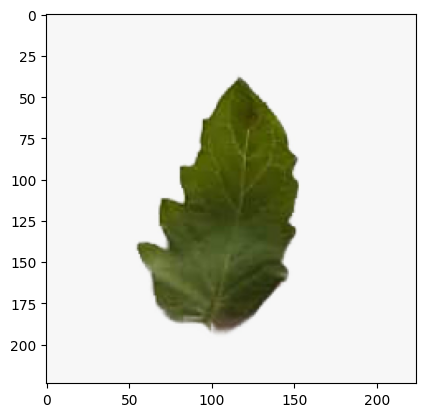

In [ ]:
import matplotlib.pyplot as plt 
plt.imshow(test_image_1)
plt.show()

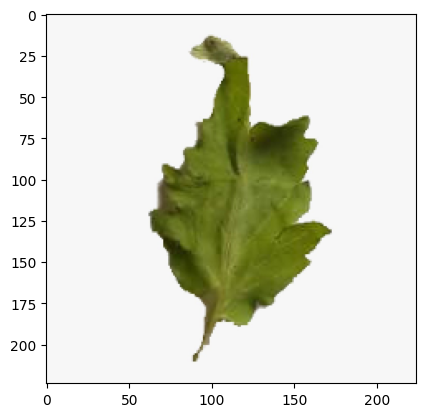

In [ ]:
plt.imshow(test_image_2)
plt.show()

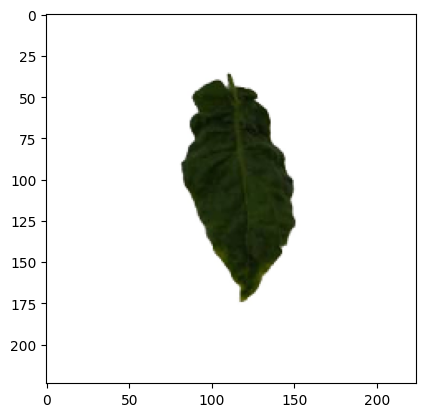

In [ ]:
plt.imshow(test_image_3)
plt.show()

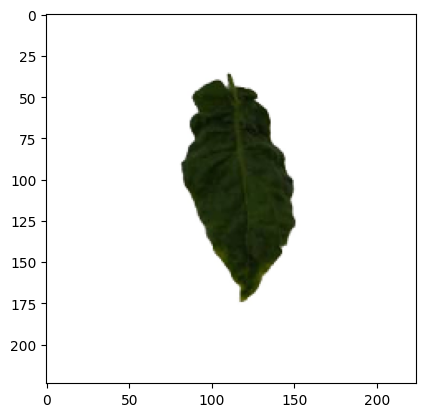

In [ ]:
plt.imshow(test_image_4)
plt.show()

In [ ]:
# convert all the images to array
test_image_1 = img_to_array(test_image_1)
test_image_2 = img_to_array(test_image_2)
test_image_3 = img_to_array(test_image_3)
test_image_4 = img_to_array(test_image_4)

In [ ]:
# normalize all the images by dividing them by 255
# to put their values in the range of 0 to 1

test_image_1 = test_image_1/255
test_image_2 = test_image_2/255
test_image_3 = test_image_3/255
test_image_4 = test_image_4/255

In [ ]:
# Creat a sample array and add all the test images
samples = []
samples.append(test_image_1)
samples.append(test_image_2)
samples.append(test_image_3)
samples.append(test_image_4)

samples = np.array(samples)

In [ ]:
# extract the features for all the samples 
features = feature_extractor.predict(samples)


1/1 [==============================] - 0s 159ms/step


In [ ]:
# our features list should contain four samplesm
len(features)

4

In [ ]:
# use the svm to get our predictions
svm_predictions = poly.predict(features)

In [ ]:
# lets see the svm predictions
svm_predictions

array([2, 2, 2, 2])

In [ ]:
# lets use the svm_predictions to get the class names 
for i,prediction in enumerate(svm_predictions):
    print(f'test_image_{i+1} is {classes[prediction]}')

test_image_1 is Tomato___Early_blight
test_image_2 is Tomato___Early_blight
test_image_3 is Tomato___Early_blight
test_image_4 is Tomato___Early_blight
